In [15]:
import numpy as np
import matplotlib.pyplot as plt
from imgaug import augmenters as iaa

In [16]:
test_noisy = np.load("data/test_noisy_100.npy")
train_noisy = np.load("data/train_noisy.npy")
train_clean = np.load("data/train_clean.npy")
train_back= np.load("data/train_background.npy")

In [17]:
def delete_random_patch(arr):
    
    num_patches = np.random.randint(5,10)
    patch_size = np.random.randint(17,20)
    div = 96 // patch_size

    for _ in range(num_patches):
        i,j = np.random.randint(0,div+1)*patch_size,np.random.randint(0,div+1)*patch_size
        arr[i:i+patch_size, j:j+patch_size,:] = 0
    
    return arr


def new_background(label):
    
    new_image = np.copy(train_back[np.random.randint(0,train_back.shape[0])])
    greyscale_image = np.mean(label, axis=2)
    mask = greyscale_image > 0
    new_image[mask,:] = label[mask,:]

    
    return new_image


In [18]:

p = 0.1
soft_transform = iaa.Sequential([
                iaa.Sometimes(p,iaa.Invert(0.25, per_channel=0.5)),
                iaa.Sometimes(p,iaa.Add((-50, 50), per_channel=0.5)),
                iaa.Sometimes(p,iaa.Multiply((0.5, 1.5), per_channel=0.5)),
                iaa.Sometimes(p,iaa.LinearContrast((0.5, 1.5), per_channel=0.5)),
                iaa.Sometimes(p,iaa.Grayscale(alpha=(0.0, 1.0))),

                iaa.Sometimes(p,iaa.OneOf([
                    iaa.GammaContrast((0.25, 5.0)),
                    iaa.GammaContrast((0.25, 5.0), per_channel=True),
                ])),
                iaa.Sometimes(p, iaa.MultiplyAndAddToBrightness(mul=(0.3, 2), add=(-100, 100))),
                iaa.Sometimes(p,iaa.AddToHueAndSaturation((-100, 100), per_channel=True)),
               
                
                ], random_order=True)


p_fake = 0.25
soft_transform_fake = iaa.Sequential([
                iaa.Sometimes(p_fake, iaa.Affine(scale=(0.97, 1.03))),
                iaa.Sometimes(p_fake,iaa.Invert(0.25, per_channel=0.5)),
                iaa.Sometimes(p_fake,iaa.Add((-100, 100), per_channel=0.5)),
                iaa.Sometimes(p_fake,iaa.Multiply((0.5, 1.5), per_channel=0.5)),
                iaa.Sometimes(p_fake,iaa.LinearContrast((0.5, 1.5), per_channel=0.5)),
                iaa.Sometimes(p_fake,iaa.Grayscale(alpha=(0.0, 1.0))),

                iaa.Sometimes(p_fake,iaa.OneOf([
                    iaa.GammaContrast((0.25, 5.0)),
                    iaa.GammaContrast((0.25, 5.0), per_channel=True),
                ])),
                iaa.Sometimes(p_fake, iaa.MultiplyAndAddToBrightness(mul=(0.3, 2), add=(-100, 100))),
                iaa.Sometimes(p_fake,iaa.AddToHueAndSaturation((-100, 100), per_channel=True)),
                ], random_order=True)


def aug_noisy(idx):

    x = np.copy(train_noisy[idx].astype(np.uint8))
    
    y = np.copy(train_clean[idx].astype(np.uint8))

    

    if np.random.rand() < 0.25:
        x = delete_random_patch(x)

    x = soft_transform.augment_image(x)

    return x,y


def aug_fake(idx):

    y = np.copy(train_clean[idx].astype(np.uint8))
    
    x = np.copy(new_background(y))
    
    if np.random.rand() < 0.75:
        x = delete_random_patch(x)
    
    x = soft_transform_fake.augment_image(x)

    
    return x,y




#### some samples of the augmentation

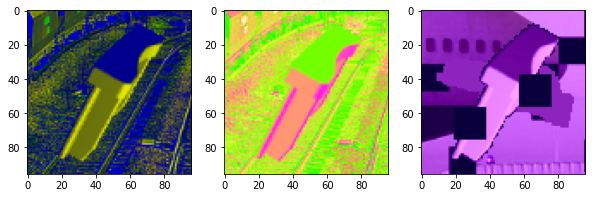

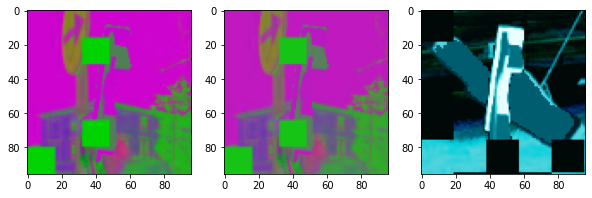

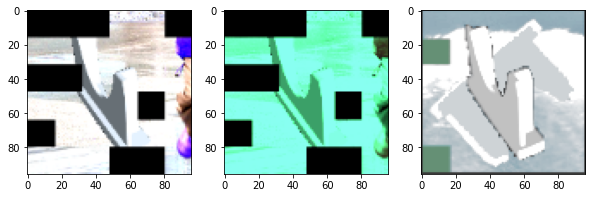

In [21]:
for i in np.random.randint(0, high=10_000, size=3):
    fig, ax = plt.subplots(1,3, figsize=(10,15))
    original = train_noisy[i]
    ax[0].imshow(original)

    original_aug = aug_noisy(i)[0]
    ax[1].imshow(original_aug)

    fake_aug = aug_fake(i)[0]
    ax[2].imshow(fake_aug)


#### next cell will generate 2 million generated images

In [26]:
n = 1_000_000

idx1 = 0
for i in range(int(n/10_000)):
    for j in range(10000):

        idx2 = idx1+1

        sample_1 = np.zeros((2,96,96,3), dtype=np.uint8)
        sample_2 = np.zeros((2,96,96,3), dtype=np.uint8)


        sample_1[0], sample_1[1] = aug_noisy(j)
        sample_2[0], sample_2[1] = aug_fake(j)

        np.save(f"./dataset/sample_{idx1}.npy", sample_1)
        np.save(f"./dataset/sample_{idx2}.npy", sample_2)


        idx1 += 2
    print(f"{i+1} / {int(n/10_000)}")
        